In [1]:
# get the KITTI dataset if not there already:
!bash ../datasets/KITTI/get_files_KITTI.sh

downloading KITTI object tracking dataset ...
--2024-06-04 22:17:41--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_tracking_image_2.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.53, 52.219.72.107, 52.219.47.63, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15813146295 (15G) [application/zip]
Saving to: ‘data_tracking_image_2.zip’

    data_tracking_i   9%[>                   ]   1.39G  5.87MB/s    eta 38m 47s^C


In [1]:
""" based on https://github.com/windowsub0406/KITTI_Tutorial/ """

' based on https://github.com/windowsub0406/KITTI_Tutorial/ '

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append("../utils/")  # Adds utils python modules path.
from kitti_foundation import Kitti, Kitti_util

%matplotlib inline

v2c_filepath = "../datasets/KITTI/2011_09_26/calib_velo_to_cam.txt"
c2c_filepath = "../datasets/KITTI/2011_09_26/calib_cam_to_cam.txt"
xml_path = "../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml"

velo_path = (
    "../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/velodyne_points/data"
)
camera_path = "../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/"

frame_no = 115
v_fov, h_fov = (-24.9, 2.0), (-90, 90)  # field of view

In [2]:
# print shapes of the data
velo = Kitti(frame=frame_no, velo_path=velo_path)
frame = velo.velo_file
print(frame.shape)

image_path = camera_path + "image_03/data"
image = Kitti(frame=frame_no, camera_path=image_path)
frame = image.camera_file
print(frame.shape)

(123749, 3)
(375, 1242, 3)


# Distributions of point counts for different lidar frames

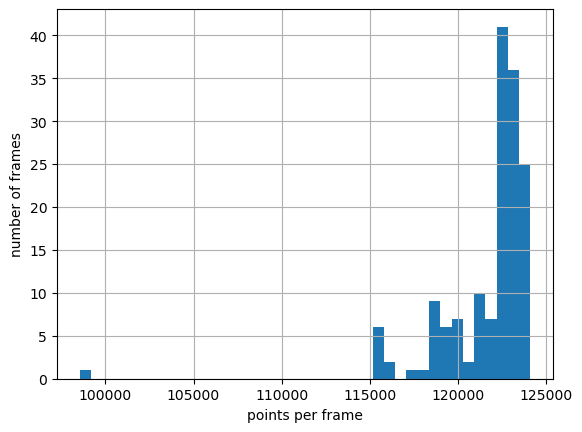

In [3]:
num_points = np.asarray(
    [
        Kitti(frame=frame_id, velo_path=velo_path).velo_file.shape[0]
        for frame_id in range(0, 154)
    ]
)
plt.grid()
plt.hist(num_points, bins=40)
# plt.yscale("log")
plt.xlabel("points per frame")
plt.ylabel("number of frames")
plt.savefig("points_per_frame.pdf", bbox_inches="tight")

# Example image from the left camera

In [5]:
def draw_tracklets(check):
    """draw 3d bounding boxes around annotated objects"""
    import cv2

    tracklet_, type_ = check.tracklet_info

    tracklet2d = []
    for i, j in zip(tracklet_[frame_no], type_[frame_no]):
        point = i.T
        chk, _ = check._Kitti_util__velo_2_img_projection(point)
        tracklet2d.append(chk)

    type_c = {
        "Car": (0, 0, 255),
        "Van": (0, 255, 0),
        "Truck": (255, 0, 0),
        "Pedestrian": (0, 255, 255),
        "Person (sitting)": (255, 0, 255),
        "Cyclist": (255, 255, 0),
        "Tram": (0, 0, 0),
        "Misc": (255, 255, 255),
    }

    line_order = (
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 4],
        [4, 0],
        [5, 1],
        [6, 2],
        [7, 3],
    )

    for i, j in zip(tracklet2d, type_[frame_no]):
        for k in line_order:
            cv2.line(
                image,
                (int(i[0][k[0]]), int(i[1][k[0]])),
                (int(i[0][k[1]]), int(i[1][k[1]])),
                type_c[j],
                2,
            )
        cv2.putText(
            image,
            j,
            (int(i[0][k[0]]), int(-10 + i[1][k[0]])),
            cv2.FONT_HERSHEY_PLAIN,
            1,
            type_c[j],
            2,
        )

parsing tracklet file ../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml
file contains 15 tracklets
loaded 15 tracklets


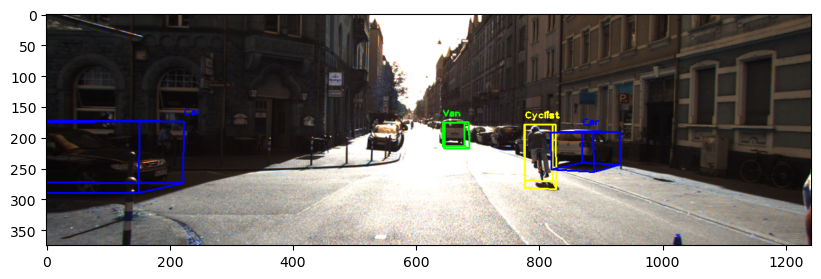

In [6]:
import matplotlib.image as mpimg
import cv2

with_tracklets = True

# read left camera image
image_type = "color"  # 'gray' or 'color' image
mode = (
    "00" if image_type == "gray" else "02"
)  # image_00 = 'gray image' , image_02 = 'color image'

image_path = camera_path + "image_" + mode + "/data"
check = Kitti_util(
    frame=frame_no,
    velo_path=velo_path,
    camera_path=image_path,
    xml_path=xml_path,
    v2c_path=v2c_filepath,
    c2c_path=c2c_filepath,
)
image = check.camera_file

txt = ""
if with_tracklets:
    draw_tracklets(check)
    txt = "_with_tracklets"

plt.title("")
plt.imshow(image)
# print(image.shape)
plt.gcf().set_size_inches(13, 3)
# plt.savefig("just_camera"+txt+".pdf", bbox_inches='tight')

## Projection of lidar points onto the same camera image

In [11]:
def print_projection_cv2(points, color, image):
    """project converted velodyne points into camera image"""

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(
            hsv_image,
            (np.int32(points[0][i]), np.int32(points[1][i])),
            2,
            (int(color[i]), 255, 255),
            -1,
        )

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)


def print_projection_plt(points, color, image):
    """project converted velodyne points into camera image"""

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(
            hsv_image,
            (np.int32(points[0][i]), np.int32(points[1][i])),
            2,
            (int(color[i]), 255, 255),
            -1,
        )

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

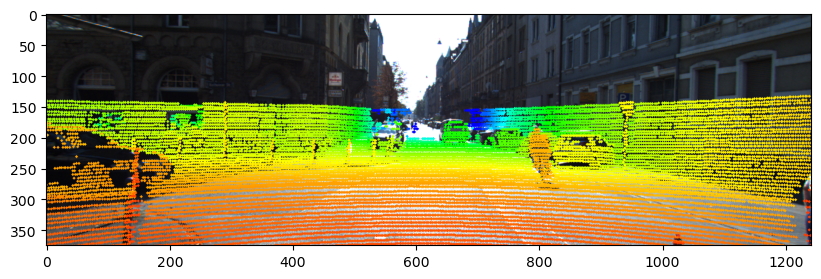

In [12]:
res = Kitti_util(
    frame=frame_no,
    camera_path=image_path,
    velo_path=velo_path,
    v2c_path=v2c_filepath,
    c2c_path=c2c_filepath,
)

img, pnt, c_ = res.velo_projection_frame(v_fov=v_fov, h_fov=h_fov)

result = print_projection_plt(pnt, c_, img)

# display result image
plt.subplots(1, 1, figsize=(13, 3))
# plt.title("Projection of velodyne lidar points to camera image")
plt.imshow(result)
# plt.xlabel("number of points per frame")
# plt.ylabel("number of frames")
# plt.savefig("velodyne_projection_front.pdf", bbox_inches='tight')

# Lidar projection as a video

Save the video file

In [ ]:
temp = Kitti(frame=0, camera_path=image_path)
img = temp.camera_file
size = (img.shape[1], img.shape[0])

""" save result video """
fourcc = cv2.VideoWriter_fourcc(*"XVID")
vid = cv2.VideoWriter("projection.avi", fourcc, 25.0, size)
test = Kitti_util(
    frame="all",
    camera_path=image_path,
    velo_path=velo_path,
    v2c_path=v2c_filepath,
    c2c_path=c2c_filepath,
)

res = test.velo_projection(v_fov=v_fov, h_fov=h_fov)

for frame, point, cc in res:
    image = print_projection_cv2(point, cc, frame)
    vid.write(image)

print("video saved")
vid.release()

video saved


Play the video file

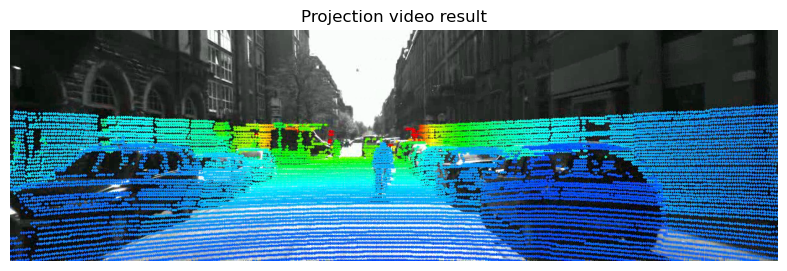

In [ ]:
from IPython.display import clear_output

""" display video """
vid = cv2.VideoCapture("./projection.avi")

while True:
    ret, frame = vid.read()
    if not ret:
        vid.release()
        break
    fig = plt.figure(figsize=(12, 3))

    plt.title("Projection video result")
    plt.axis("off")
    plt.imshow(frame)
    plt.show()
    # clear current frame for next frame
    clear_output(wait=True)

vid.release()

# Visualisations of lidar data alone

### Top view

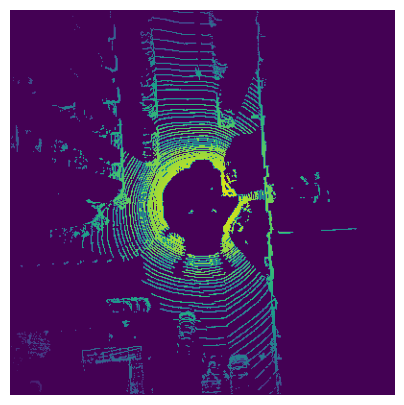

In [102]:
velo = Kitti_util(frame=150, velo_path=velo_path)

x_range, y_range, z_range, scale = (-20, 20), (-20, 20), (-2, 2), 10
topview_img = velo.velo_2_topview_frame(
    x_range=x_range, y_range=y_range, z_range=z_range
)

# Plot result
plt.subplots(1, 1, figsize=(5, 5))
plt.imshow(topview_img)
plt.axis("off")
plt.savefig("lidar_top_view.pdf", bbox_inches="tight")

save topview video

In [ ]:
# pre define range for image size
x_range, y_range, scale = (-20, 20), (-20, 20), 10
size = (
    int((max(x_range) - min(x_range)) * scale),
    int((max(y_range) - min(y_range)) * scale),
)

velo2 = Kitti_util(frame="all", velo_path=velo_path)
topview = velo2.velo_2_topview(
    x_range=x_range, y_range=y_range, z_range=z_range, scale=scale
)

""" save top view video """
fourcc = cv2.VideoWriter_fourcc(*"XVID")
vid = cv2.VideoWriter("topview.avi", fourcc, 25.0, size, False)

for frame in topview:
    vid.write(frame)

print("video saved")
vid.release()

play topview video

In [ ]:
from IPython.display import clear_output

""" display video """
vid = cv2.VideoCapture("./topview.avi")

while True:
    ret, frame = vid.read()
    if not ret:
        vid.release()
        break
    fig = plt.figure(figsize=(12, 5))

    plt.title("Topview video result")
    plt.axis("off")
    plt.imshow(frame)
    plt.show()
    # clear current frame for next frame
    clear_output(wait=True)

vid.release()

In [103]:
check = Kitti_util(
    frame=frame_no,
    velo_path=velo_path,
    camera_path=image_path,
    xml_path=xml_path,
    v2c_path=v2c_filepath,
    c2c_path=c2c_filepath,
)

# bring velo points & tracklet info
points = check.velo_file
tracklet_, type_ = check.tracklet_info

print(points.shape)
print("The number of GT : ", len(tracklet_[frame_no]))

parsing tracklet file ../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml
file contains 15 tracklets
loaded 15 tracklets
(121649, 3)
The number of GT :  4


### 3D projection

In [104]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


def draw_3d_box(tracklet_, type_, ax, show_tracklets=True):
    """draw 3d bounding box"""

    type_c = {
        "Car": "b",
        "Van": "g",
        "Truck": "r",
        "Pedestrian": "c",
        "Person (sitting)": "m",
        "Cyclist": "y",
        "Tram": "k",
        "Misc": "w",
    }

    line_order = (
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 4],
        [4, 0],
        [5, 1],
        [6, 2],
        [7, 3],
    )

    if show_tracklets:
        # draw the tracklets:
        for i, j in zip(tracklet_[frame_no], type_[frame_no]):
            for k in line_order:
                ax.plot3D(*zip(i.T[k[1]], i.T[k[0]]), lw=1.5, color=type_c[j])

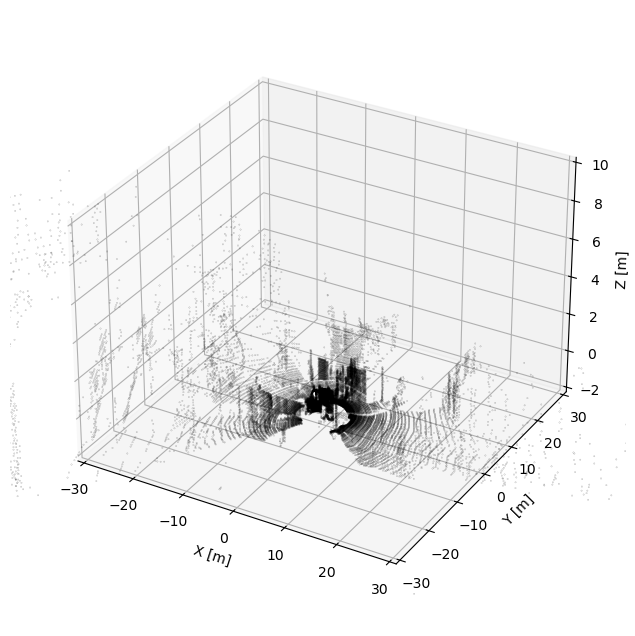

In [106]:
with_tracklets = False

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection="3d")

draw_3d_box(tracklet_, type_, ax=ax, show_tracklets=with_tracklets)

# plt.title("3D Tracklet display")
pnt = points.T[:, 1::5]  # one point in 5 points

ax.scatter(*pnt, s=0.1, c="k", marker=".", alpha=0.5)


ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")

ax.set_xlim3d(-30, 30)
ax.set_ylim3d(-30, 30)
ax.set_zlim3d(-2, 10)

ax.set_box_aspect(aspect=None, zoom=0.92)
if with_tracklets:
    txt = "_with_tracklets"
else:
    txt = ""
plt.savefig("3D_lidar" + txt + ".pdf", bbox_inches="tight")